In [1]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import label_binarize
from scipy.stats import shapiro
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Load lipid data

In [7]:
lipid_data_df = pd.read_csv(f'all_data.csv')

In [3]:
lipid_data_df

,Date,Blood Type,Person,Cer d18:2_16:0,Cer d18:1_18:0,Cer d18:1_18:1,Cer d18:1_16:0,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,...,LPC 22:6 SN1,LPC O-22:1,PC 18:0_16:0,PC 18:0_22:5,PC 19:0_20:4,PC O-18:0_22:4,PC O-18:2_20:4,PC O-24:2_20:4,PE O-18:3_20:4,PI 18:0_22:5
0,210625,Plasma,1,0.05,0.27,0.08,0.52,0.82,3.37,9.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210625,Serum,1,0.05,0.30,0.08,0.58,0.84,4.08,11.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,210625,Blood EDTA - Serum,1,0.07,0.82,0.11,1.71,0.88,4.12,11.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210625,DBS - Venous,1,0.07,0.42,0.06,1.08,0.43,3.09,5.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,210625,DBS - Finger,1,0.06,0.32,0.05,0.89,0.37,2.23,4.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,210702,Plasma,1,0.04,0.25,0.11,0.47,0.72,3.74,10.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,210702,Serum,1,0.22,0.46,0.22,0.78,1.53,7.33,20.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,210702,Blood EDTA - Serum,1,0.11,1.32,0.17,3.60,0.90,4.81,12.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,210702,DBS - Venous,1,0.08,0.46,0.06,1.27,0.52,3.47,6.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,210702,DBS - Finger,1,0.04,0.33,0.06,0.80,0.33,2.21,4.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Pair-wise scatter plots

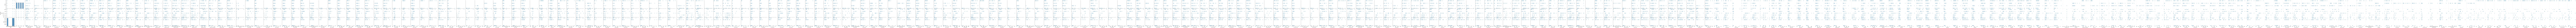

In [90]:
sns.pairplot(lipid_data_df, y_vars=["Person", 'Blood Type', 'Date'])

# Dimension reduction

## PCA

In [9]:
lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
plasma = lipid_data_df_without_na[lipid_data_df_without_na['Blood Type'] == 'Plasma']
serum = lipid_data_df_without_na[lipid_data_df_without_na['Blood Type'] == 'Serum']
blood_edta = lipid_data_df_without_na[lipid_data_df_without_na['Blood Type'] == 'Blood EDTA - Serum']
dbs_venous = lipid_data_df_without_na[lipid_data_df_without_na['Blood Type'] == 'DBS - Venous']
dbs_finger = lipid_data_df_without_na[lipid_data_df_without_na['Blood Type'] == 'DBS - Finger']
blood_type_dict = {'Plasma': plasma, 
              'Serum':serum,
              'Blood EDTA - Serum': blood_edta,
              'DBS - Venous': dbs_venous,
              'DBS - Finger': dbs_finger}

In [10]:
pca = PCA(n_components=2)
lipid_data_df_without_na_normalized = (lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date'])-
                            lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date']).mean())/lipid_data_df_without_na.drop(
    columns=['Person', 'Blood Type', 'Date']).std()
projected_lipid_data = pca.fit_transform(lipid_data_df_without_na_normalized)
pca.explained_variance_ratio_

array([0.39384317, 0.21649259])

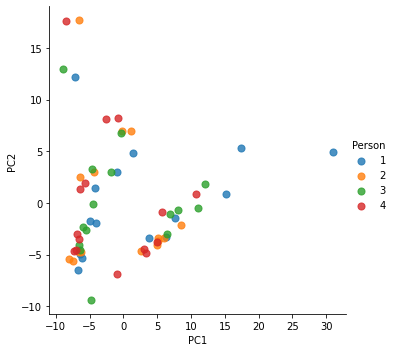

In [11]:
pc_df = pd.DataFrame(data = projected_lipid_data , 
        columns = ['PC1', 'PC2'])
pc_df['Blood Type'] = lipid_data_df['Blood Type']
pc_df['Person'] = lipid_data_df['Person']

lmplot_persons = sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Person', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_persons.savefig('persons_pca.pdf')

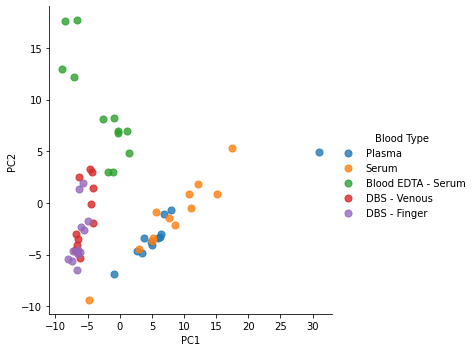

In [12]:
lmplot_type = sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Blood Type', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_type.savefig('type_pca.pdf')

## t-SNE

In [13]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
projected_lipid_data = tsne.fit_transform(lipid_data_df_without_na_normalized)

/home/tony/.virtualenvs/lipid-study/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


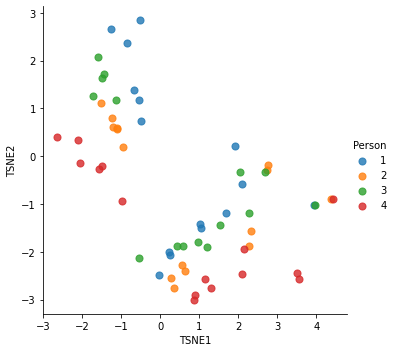

In [14]:
pc_df = pd.DataFrame(data = projected_lipid_data , 
        columns = ['TSNE1', 'TSNE2'])
pc_df['Blood Type'] = lipid_data_df['Blood Type']
pc_df['Person'] = lipid_data_df['Person']

lmplot_persons = sns.lmplot( x="TSNE1", y="TSNE2",
  data=pc_df, 
  fit_reg=False, 
  hue='Person', # color by cluster
  legend=True,
  scatter_kws={"s": 50}) # specify the point size
lmplot_persons.savefig('persons_tsne.pdf')

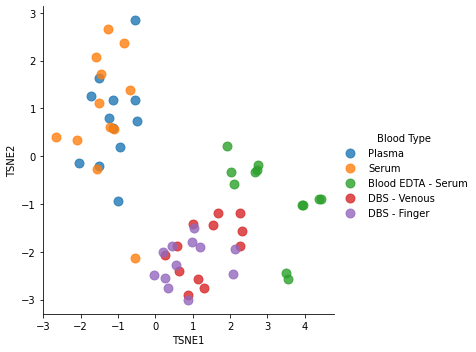

In [15]:
lmplot_type = sns.lmplot( x="TSNE1", y="TSNE2",
  data=pc_df, 
  fit_reg=False, 
  hue='Blood Type', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size
lmplot_type.savefig('type_tsne.pdf')

# Compare intergroup differences

## Shapiro-Wilk test for normality

In [16]:
for key, value in blood_type_dict.items():
    counter = 0
    column = []
    for k in value.drop(columns=['Person', 'Blood Type', 'Date']).keys():
        _, pvalue = shapiro(value[k])
        if pvalue <= 0.01:
            counter += 1
    print(f'Number of rejected normal distributed variables: {counter} in {key}')

Number of rejected normal distributed variables: 60 in Plasma
Number of rejected normal distributed variables: 17 in Serum
Number of rejected normal distributed variables: 30 in Blood EDTA - Serum
Number of rejected normal distributed variables: 19 in DBS - Venous
Number of rejected normal distributed variables: 21 in DBS - Finger


## Wilcoxon signed-rank test

<AxesSubplot:>

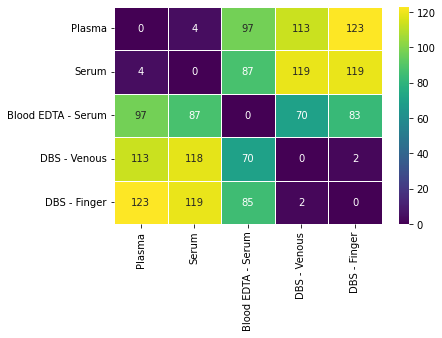

In [21]:
matrix = []
for first_key, first_value in blood_type_dict.items():
    column = []
    for second_key, second_value in blood_type_dict.items():
        counter = 0
        if first_key != second_key:
            for k in first_value.drop(columns=['Person', 'Blood Type', 'Date']).keys():
                statistics, pvalue = stats.wilcoxon(first_value[k], second_value[k])
                if pvalue <= 0.01:
                    counter += 1
        column.append(counter)
    matrix.append(column)

sns.heatmap(matrix, annot=True, linewidths=0.5, cmap='viridis',
            xticklabels=blood_type_dict.keys(), yticklabels=blood_type_dict.keys(), fmt='g')

# Train classifier

In [22]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 4]
lw = 2
# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_forest = RandomForestClassifier()

## Multiclass

In [34]:
all_true = []
all_prediction = []
num_classes = len(lipid_data_df_without_na['Blood Type'].unique())
confusion_matrix_type = np.zeros([num_classes, num_classes])
lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
lipid_x = lipid_data_df_without_na.drop(columns=['Person', 'Blood Type', 'Date'])
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df_without_na['Blood Type'])
auroc_list = []
outer_groups = lipid_data_df_without_na['Person']
logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
    train_val_data = lipid_x.loc[train_index]
    test_data = lipid_x.loc[test_index]
    blood_type_test_val = blood_type[train_index]
    blood_type_test = blood_type[test_index]
    inner_groups = outer_groups.loc[train_index]
    grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                          cv = logo, n_jobs = -1, verbose = 1)
    clf = grid_search.fit(train_val_data,  blood_type_test_val, groups = inner_groups)
    
    # test stuff
    y_pred_proba = clf.predict_proba(test_data)
    y_pred = clf.predict(test_data)
    all_true.extend(blood_type_test)
    all_prediction.extend(y_pred_proba)
    confusion_matrix_type += confusion_matrix(blood_type_test, y_pred)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits


In [35]:
data = {'lipid': lipid_x.keys(), 'Importance': clf.best_estimator_.feature_importances_}
importance_df = pd.DataFrame(data)
importance_df.sort_values('Importance', ascending=False)

,lipid,Importance
109,PE O-18:1_18:1,0.032643
99,PE 18:0_18:1,0.027783
145,SM d38:1,0.027095
153,SM d44:2,0.023646
96,PE 16:0_18:2,0.023568
...,...,...
138,SM d33:2,0.000000
11,Hex2Cer 32:1;2O,0.000000
35,LPC O-18:1,0.000000
20,LPC 14:0 SN1,0.000000


<AxesSubplot:>

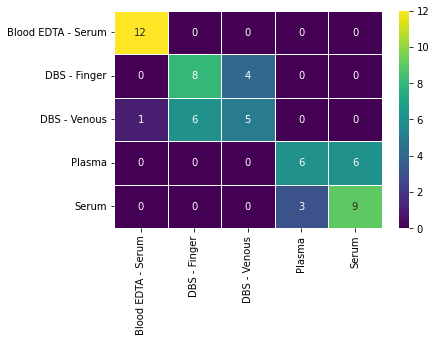

In [36]:
sns.heatmap(confusion_matrix_type, annot=True, linewidths=1, cmap='viridis',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

In [37]:
roc_auc_score(all_true, all_prediction, multi_class='ovr')

0.914236111111111

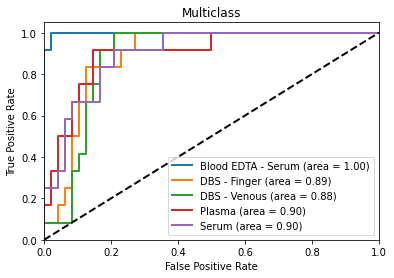

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    type_true = np.array([1 if y == i else 0 for y in all_true])
    fpr[i], tpr[i], _ = roc_curve(type_true, np.array(all_prediction)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], lw=lw,
        label=f"{label_encoder.inverse_transform([i])[0]} (area = {roc_auc[i]:0.2f})"
    )


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#plt.plot(
#    fpr["macro"],
#    tpr["macro"],
#    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#    color="navy",
#    linestyle=":",
 #   linewidth=4)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('multiclass_classifier.pdf')
plt.show()

## OvR

In [39]:
all_true = []
all_prediction = []

lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
lipid_x = lipid_data_df_without_na.drop(columns=['Person', 'Blood Type', 'Date'])
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df['Blood Type'])
clf_list = []

outer_groups = lipid_data_df_without_na['Person']
logo = LeaveOneGroupOut()

for one_type in range(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_group = []
    for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
        ovr_blood_type = np.array([1 if y == one_type else 0 for y in blood_type])
        train_val_data = lipid_x.loc[train_index]
        test_data = lipid_x.loc[test_index]
        blood_type_test_val = ovr_blood_type[train_index]
        blood_type_test = ovr_blood_type[test_index]
        inner_groups = outer_groups.loc[train_index]
        grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                              cv = logo, n_jobs = -1, verbose = 1)
        clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)
        clf_list.append(clf)

        # test stuff
        y_pred_proba = clf.predict_proba(test_data)
        y_pred = clf.predict(test_data)
        all_true_type.extend(blood_type_test)
        all_prediction_group.extend(y_pred_proba)
    all_true.append(all_true_type)
    all_prediction.append(all_prediction_group)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

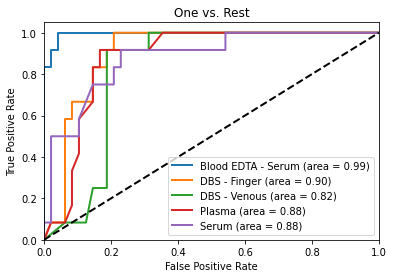

In [40]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(all_true[i], np.array(all_prediction[i])[:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], lw=lw,
        label=f"{label_encoder.inverse_transform([i])[0]} (area = {roc_auc[i]:0.2f})"
    )


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#plt.plot(
#    fpr["macro"],
#    tpr["macro"],
#    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#    color="navy",
#    linestyle=":",
#    linewidth=4)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('One vs. Rest')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('one_vs_rest_classifier.pdf')
plt.show()

## OVO

In [41]:
all_true = []
all_prediction = []

lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df['Blood Type'])

logo = LeaveOneGroupOut()

for one_type in range(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_type = []

    for second_one_type in range(len(label_encoder.classes_)):
        if one_type == second_one_type:
            all_true_type.append([])
            all_prediction_type.append([])
            continue
        d = {one_type: 1, second_one_type: 0}
        ovo_blood_type = np.array([d[y]  for y in blood_type if y in d])
        indices = np.nonzero(np.isin(blood_type, [one_type, second_one_type]))
        outer_groups = lipid_data_df_without_na.loc[indices[0]]['Person']
        lipid_x = lipid_data_df_without_na.loc[indices[0]].drop(columns=['Person', 'Blood Type', 'Date'])
        all_prediction_ovo = []
        all_true_ovo = []
        for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
            train_val_data = lipid_x.iloc[train_index]
            test_data = lipid_x.iloc[test_index]
            blood_type_test_val = ovo_blood_type[train_index]
            blood_type_test = ovo_blood_type[test_index]
            inner_groups = outer_groups.iloc[train_index]
            grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                                  cv = logo, n_jobs = -1, verbose = 1)
            clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)

            
            # test stuff
            y_pred_proba = clf.predict_proba(test_data)
            y_pred = clf.predict(test_data)
            all_true_ovo.extend(blood_type_test)
            all_prediction_ovo.extend(y_pred_proba)
        all_true_type.append(all_true_ovo)
        all_prediction_type.append(all_prediction_ovo)
    all_true.append(all_true_type)
    all_prediction.append(all_prediction_type)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

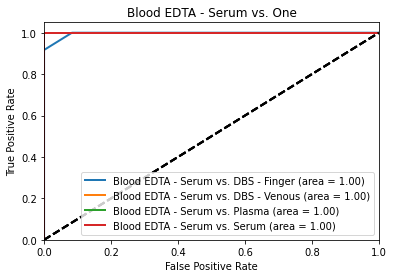

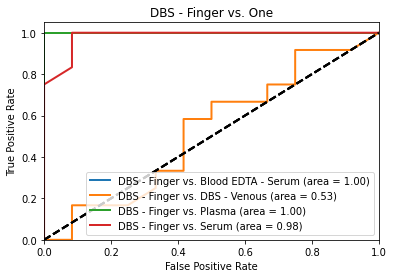

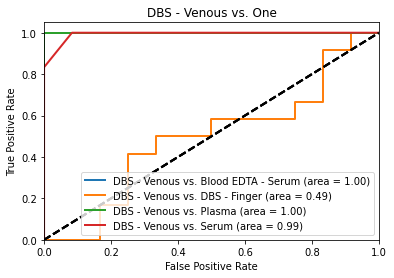

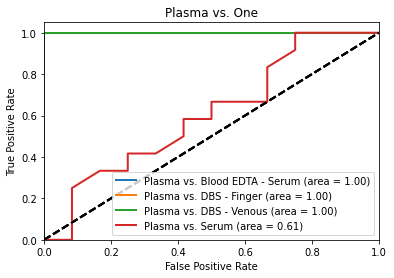

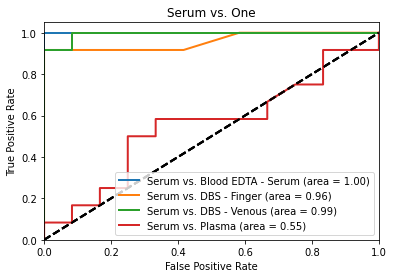

In [43]:
for one_type in range(len(label_encoder.classes_)):
    for second_one_type in range(len(label_encoder.classes_)):
        if one_type == second_one_type:
            continue
        all_true_ovo = all_true[one_type][second_one_type]
        all_prediction_ovo = all_prediction[one_type][second_one_type]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        lw = 2


        fpr, tpr, _ = roc_curve(all_true_ovo, np.array(all_prediction_ovo)[:,1])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
            label=f"{label_encoder.inverse_transform([one_type])[0]}"\
                 f" vs. {label_encoder.inverse_transform([second_one_type])[0]} (area = {roc_auc:0.2f})")

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f'{label_encoder.inverse_transform([one_type])[0]} vs. One')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    plt.savefig(f'{label_encoder.inverse_transform([one_type])[0]}_vs_one_classifier.pdf')
    plt.show()